# Batch Normalization

In this notebook, you will implement the batch normalization layers of a neural network to increase its performance.  If you have any confusion, please review the details of batch normalization from the lecture notes.

CS231n has built a solid API for building these modular frameworks and training them, and we will use their very well implemented framework as opposed to "reinventing the wheel."  This includes using their Solver, various utility functions, and their layer structure.  This also includes nndl.fc_net, nndl.layers, and nndl.layer_utils.  As in prior assignments, we thank Serena Yeung & Justin Johnson for permission to use code written for the CS 231n class (cs231n.stanford.edu).  

In [1]:
## Import and setups

import time
import numpy as np
import matplotlib.pyplot as plt
import warnings
from nndl.fc_net import *
from nndl.layers import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.solver import Solver
warnings.filterwarnings("ignore")


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [2]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k in data.keys():
  print('{}: {} '.format(k, data[k].shape))

X_train: (49000, 3, 32, 32) 
y_train: (49000,) 
X_val: (1000, 3, 32, 32) 
y_val: (1000,) 
X_test: (1000, 3, 32, 32) 
y_test: (1000,) 


## Batchnorm forward pass

Implement the training time batchnorm forward pass, `batchnorm_forward`, in `nndl/layers.py`. After that, test your implementation by running the following cell.

In [3]:
# Check the training-time forward pass by checking means and variances
# of features both before and after batch normalization

# Simulate the forward pass for a two-layer network
N, D1, D2, D3 = 200, 50, 60, 3
X = np.random.randn(N, D1)
W1 = np.random.randn(D1, D2)
W2 = np.random.randn(D2, D3)
a = np.maximum(0, X.dot(W1)).dot(W2)

print('Before batch normalization:')
print('  means: ', a.mean(axis=0))
print('  stds: ', a.std(axis=0))

# Means should be close to zero and stds close to one
print('After batch normalization (gamma=1, beta=0)')
a_norm, _ = batchnorm_forward(a, np.ones(D3), np.zeros(D3), {'mode': 'train'})
print('  mean: ', a_norm.mean(axis=0))
print('  std: ', a_norm.std(axis=0))

# Now means should be close to beta and stds close to gamma
gamma = np.asarray([1.0, 2.0, 3.0])
beta = np.asarray([11.0, 12.0, 13.0])
a_norm, _ = batchnorm_forward(a, gamma, beta, {'mode': 'train'})
print('After batch normalization (nontrivial gamma, beta)')
print('  means: ', a_norm.mean(axis=0))
print('  stds: ', a_norm.std(axis=0))

Before batch normalization:
  means:  [-42.94018006 -11.81870505  25.58099969]
  stds:  [33.36916624 26.12949939 33.79599436]
After batch normalization (gamma=1, beta=0)
  mean:  [-5.47895063e-16  2.30718222e-16 -3.09752224e-16]
  std:  [1.         0.99999999 1.        ]
After batch normalization (nontrivial gamma, beta)
  means:  [11. 12. 13.]
  stds:  [1.         1.99999999 2.99999999]


Implement the testing time batchnorm forward pass, `batchnorm_forward`, in `nndl/layers.py`. After that, test your implementation by running the following cell.

In [4]:
# Check the test-time forward pass by running the training-time
# forward pass many times to warm up the running averages, and then
# checking the means and variances of activations after a test-time
# forward pass.

N, D1, D2, D3 = 200, 50, 60, 3
W1 = np.random.randn(D1, D2)
W2 = np.random.randn(D2, D3)

bn_param = {'mode': 'train'}
gamma = np.ones(D3)
beta = np.zeros(D3)
for t in np.arange(50):
    X = np.random.randn(N, D1)
    a = np.maximum(0, X.dot(W1)).dot(W2)
    batchnorm_forward(a, gamma, beta, bn_param)
bn_param['mode'] = 'test'
X = np.random.randn(N, D1)
a = np.maximum(0, X.dot(W1)).dot(W2)
a_norm, _ = batchnorm_forward(a, gamma, beta, bn_param)

# Means should be close to zero and stds close to one, but will be
# noisier than training-time forward passes.
print('After batch normalization (test-time):')
print('  means: ', a_norm.mean(axis=0))
print('  stds: ', a_norm.std(axis=0))

After batch normalization (test-time):
  means:  [-0.02797284 -0.00413238 -0.14542568]
  stds:  [0.96226503 1.00957277 1.00031252]


## Batchnorm backward pass

Implement the backward pass for the batchnorm layer, `batchnorm_backward` in `nndl/layers.py`.  Check your implementation by running the following cell.

In [5]:
# Gradient check batchnorm backward pass

N, D = 4, 5
x = 5 * np.random.randn(N, D) + 12
gamma = np.random.randn(D)
beta = np.random.randn(D)
dout = np.random.randn(N, D)

bn_param = {'mode': 'train'}
fx = lambda x: batchnorm_forward(x, gamma, beta, bn_param)[0]
fg = lambda a: batchnorm_forward(x, gamma, beta, bn_param)[0]
fb = lambda b: batchnorm_forward(x, gamma, beta, bn_param)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
da_num = eval_numerical_gradient_array(fg, gamma, dout)
db_num = eval_numerical_gradient_array(fb, beta, dout)

_, cache = batchnorm_forward(x, gamma, beta, bn_param)
dx, dgamma, dbeta = batchnorm_backward(dout, cache)
print('dx error: ', rel_error(dx_num, dx))
print('dgamma error: ', rel_error(da_num, dgamma))
print('dbeta error: ', rel_error(db_num, dbeta))

dx error:  5.210785607079807e-09
dgamma error:  8.399001826049228e-12
dbeta error:  7.286935869955949e-11


## Implement a fully connected neural network with batchnorm layers

Modify the `FullyConnectedNet()` class in `nndl/fc_net.py` to incorporate batchnorm layers.  You will need to modify the class in the following areas:

(1) The gammas and betas need to be initialized to 1's and 0's respectively in `__init__`.

(2) The `batchnorm_forward` layer needs to be inserted between each affine and relu layer (except in the output layer) in a forward pass computation in `loss`.  You may find it helpful to write an `affine_batchnorm_relu()` layer in `nndl/layer_utils.py` although this is not necessary.

(3) The `batchnorm_backward` layer has to be appropriately inserted when calculating gradients.

After you have done the appropriate modifications, check your implementation by running the following cell.

Note, while the relative error for W3 should be small, as we backprop gradients more, you may find the relative error increases.  Our relative error for W1 is on the order of 1e-4.

In [6]:
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for reg in [0, 3.14]:
    print('Running check with reg = ', reg)
    model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            reg=reg, weight_scale=5e-2, dtype=np.float64,
                            use_batchnorm=True)

    loss, grads = model.loss(X, y)
    print('Initial loss: ', loss)

    for name in sorted(grads):
        f = lambda _: model.loss(X, y)[0]
        grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
        print('{} relative error: {}'.format(name, rel_error(grad_num, grads[name])))
    if reg == 0: print('\n')

Running check with reg =  0
Initial loss:  2.3936910523271475
W1 relative error: 0.0001522797354093649
W2 relative error: 1.698104219605202e-05
W3 relative error: 5.004614742834353e-10
b1 relative error: 0.002220557071552775
b2 relative error: 1.7763568394002505e-07
b3 relative error: 1.63592732724398e-10
beta1 relative error: 5.765284311210593e-09
beta2 relative error: 3.678415701980516e-09
gamma1 relative error: 5.350413836239348e-09
gamma2 relative error: 5.627833221796626e-09


Running check with reg =  3.14
Initial loss:  6.8192220649684305
W1 relative error: 3.190492034597877e-05
W2 relative error: 0.00014081999523854214
W3 relative error: 1.5793641261252225e-07
b1 relative error: 6.661338147750939e-06
b2 relative error: 1.1102230246251565e-07
b3 relative error: 1.79352478321688e-10
beta1 relative error: 1.1206176462713325e-08
beta2 relative error: 5.60039723301209e-09
gamma1 relative error: 1.1358003746072446e-08
gamma2 relative error: 4.613564253182515e-09


## Training a deep fully connected network with batch normalization.

To see if batchnorm helps, let's train a deep neural network with and without batch normalization.

In [7]:
# Try training a very deep net with batchnorm
hidden_dims = [100, 100, 100, 100, 100]

num_train = 1000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

weight_scale = 2e-2
bn_model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, use_batchnorm=True)
model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, use_batchnorm=False)

bn_solver = Solver(bn_model, small_data,
                num_epochs=10, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=200)
bn_solver.train()

solver = Solver(model, small_data,
                num_epochs=10, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=200)
solver.train()

(Iteration 1 / 200) loss: 2.300020
(Epoch 0 / 10) train acc: 0.140000; val_acc: 0.138000
(Epoch 1 / 10) train acc: 0.345000; val_acc: 0.275000
(Epoch 2 / 10) train acc: 0.405000; val_acc: 0.302000
(Epoch 3 / 10) train acc: 0.482000; val_acc: 0.296000
(Epoch 4 / 10) train acc: 0.542000; val_acc: 0.326000
(Epoch 5 / 10) train acc: 0.576000; val_acc: 0.325000
(Epoch 6 / 10) train acc: 0.653000; val_acc: 0.327000
(Epoch 7 / 10) train acc: 0.691000; val_acc: 0.318000
(Epoch 8 / 10) train acc: 0.728000; val_acc: 0.329000
(Epoch 9 / 10) train acc: 0.777000; val_acc: 0.323000
(Epoch 10 / 10) train acc: 0.799000; val_acc: 0.321000
(Iteration 1 / 200) loss: 2.301939
(Epoch 0 / 10) train acc: 0.152000; val_acc: 0.148000
(Epoch 1 / 10) train acc: 0.264000; val_acc: 0.247000
(Epoch 2 / 10) train acc: 0.318000; val_acc: 0.272000
(Epoch 3 / 10) train acc: 0.325000; val_acc: 0.284000
(Epoch 4 / 10) train acc: 0.389000; val_acc: 0.289000
(Epoch 5 / 10) train acc: 0.453000; val_acc: 0.307000
(Epoch 6 / 

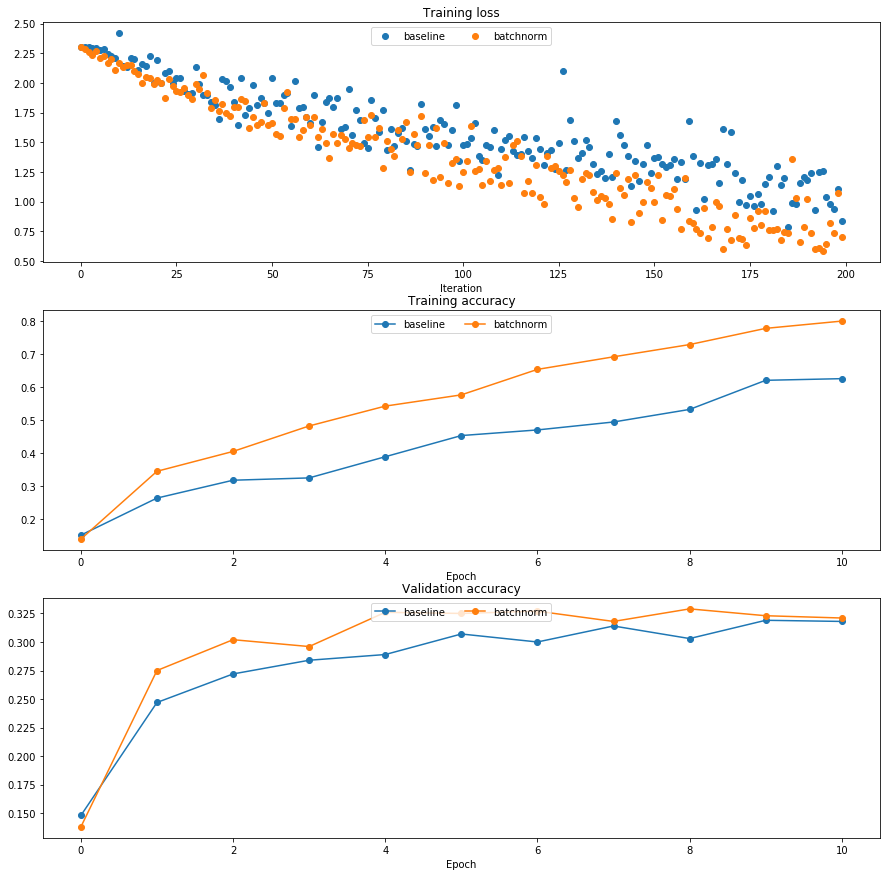

In [8]:
plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 1)
plt.plot(solver.loss_history, 'o', label='baseline')
plt.plot(bn_solver.loss_history, 'o', label='batchnorm')

plt.subplot(3, 1, 2)
plt.plot(solver.train_acc_history, '-o', label='baseline')
plt.plot(bn_solver.train_acc_history, '-o', label='batchnorm')

plt.subplot(3, 1, 3)
plt.plot(solver.val_acc_history, '-o', label='baseline')
plt.plot(bn_solver.val_acc_history, '-o', label='batchnorm')
  
for i in [1, 2, 3]:
    plt.subplot(3, 1, i)
    plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

## Batchnorm and initialization

The following cells run an experiment where for a deep network, the initialization is varied.  We do training for when batchnorm layers are and are not included.

In [9]:
# Try training a very deep net with batchnorm
hidden_dims = [50, 50, 50, 50, 50, 50, 50]

num_train = 1000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

bn_solvers = {}
solvers = {}
weight_scales = np.logspace(-4, 0, num=20)
for i, weight_scale in enumerate(weight_scales):
    print('Running weight scale {} / {}'.format(i + 1, len(weight_scales)))
    bn_model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, use_batchnorm=True)
    model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, use_batchnorm=False)

    bn_solver = Solver(bn_model, small_data,
                  num_epochs=10, batch_size=50,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': 1e-3,
                  },
                  verbose=False, print_every=200)
    bn_solver.train()
    bn_solvers[weight_scale] = bn_solver

    solver = Solver(model, small_data,
                  num_epochs=10, batch_size=50,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': 1e-3,
                  },
                  verbose=False, print_every=200)
    solver.train()
    solvers[weight_scale] = solver

Running weight scale 1 / 20
Running weight scale 2 / 20
Running weight scale 3 / 20
Running weight scale 4 / 20
Running weight scale 5 / 20
Running weight scale 6 / 20
Running weight scale 7 / 20
Running weight scale 8 / 20
Running weight scale 9 / 20
Running weight scale 10 / 20
Running weight scale 11 / 20
Running weight scale 12 / 20
Running weight scale 13 / 20
Running weight scale 14 / 20
Running weight scale 15 / 20
Running weight scale 16 / 20
Running weight scale 17 / 20
Running weight scale 18 / 20
Running weight scale 19 / 20
Running weight scale 20 / 20


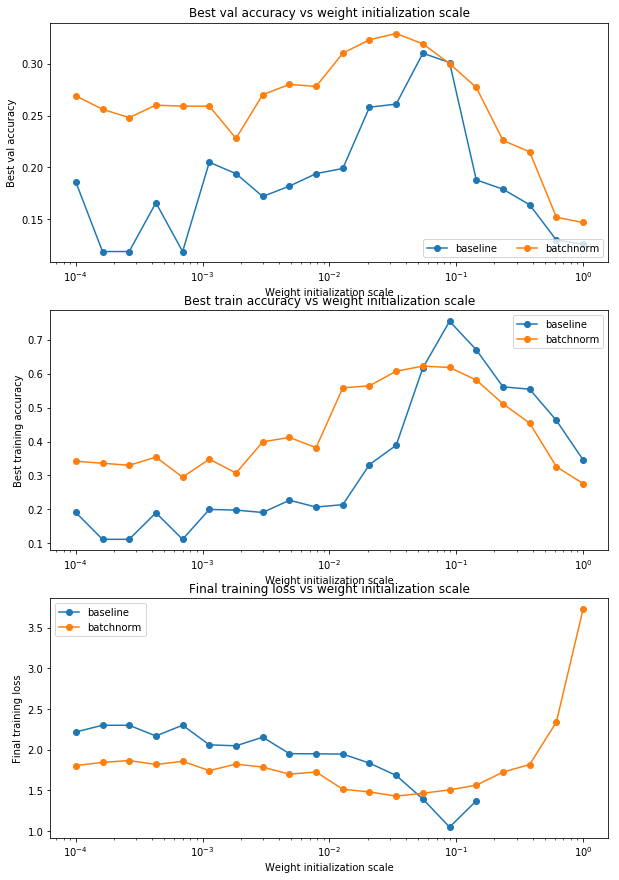

In [10]:
# Plot results of weight scale experiment
best_train_accs, bn_best_train_accs = [], []
best_val_accs, bn_best_val_accs = [], []
final_train_loss, bn_final_train_loss = [], []

for ws in weight_scales:
    best_train_accs.append(max(solvers[ws].train_acc_history))
    bn_best_train_accs.append(max(bn_solvers[ws].train_acc_history))

    best_val_accs.append(max(solvers[ws].val_acc_history))
    bn_best_val_accs.append(max(bn_solvers[ws].val_acc_history))

    final_train_loss.append(np.mean(solvers[ws].loss_history[-100:]))
    bn_final_train_loss.append(np.mean(bn_solvers[ws].loss_history[-100:]))
  
plt.subplot(3, 1, 1)
plt.title('Best val accuracy vs weight initialization scale')
plt.xlabel('Weight initialization scale')
plt.ylabel('Best val accuracy')
plt.semilogx(weight_scales, best_val_accs, '-o', label='baseline')
plt.semilogx(weight_scales, bn_best_val_accs, '-o', label='batchnorm')
plt.legend(ncol=2, loc='lower right')

plt.subplot(3, 1, 2)
plt.title('Best train accuracy vs weight initialization scale')
plt.xlabel('Weight initialization scale')
plt.ylabel('Best training accuracy')
plt.semilogx(weight_scales, best_train_accs, '-o', label='baseline')
plt.semilogx(weight_scales, bn_best_train_accs, '-o', label='batchnorm')
plt.legend()

plt.subplot(3, 1, 3)
plt.title('Final training loss vs weight initialization scale')
plt.xlabel('Weight initialization scale')
plt.ylabel('Final training loss')
plt.semilogx(weight_scales, final_train_loss, '-o', label='baseline')
plt.semilogx(weight_scales, bn_final_train_loss, '-o', label='batchnorm')
plt.legend()

plt.gcf().set_size_inches(10, 15)
plt.show()

## Question:

In the cell below, summarize the findings of this experiment, and WHY these results make sense.

## Answer:

According to the first two figures above, batch normalization increase the accuracy of the model, and batch normalization improves the tolerance of initial weights scale of the model. Because batch normalization regularizes the model, which makes the input to each layer have zero mean and unit variance. Regularization reduces overfitting which leads to better test performance through better generalization. 
Furthermore, as for the last graph, batch normalization has restrained the loss from blowing up too quick, which caused by the normalization of the ReLU's inputs. After these normalized values passed the ReLU layer, the scale of these activations stays in a low level and can also keep the weights in a normal scale.